### First Unet Tests

all code modified from https://github.com/milesial/Pytorch-UNet/tree/e36c782fbfc976b7326182a47dd7213bd3360a7e

In [1]:
import argparse
import logging
import sys
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

from segmentation.unet_utils.data_loading import BasicDataset, CarvanaDataset
from segmentation.unet_utils.dice_score import dice_loss, multiclass_dice_coeff, dice_coeff
from segmentation.unet import UNet

base_data_path = '/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/data' # change for your own system

# dir_img = Path('./data/imgs/')
dir_img = Path('C:/2022_Summer_Intern/UNet_Training_With_Images/Carvana/Input')
# dir_mask = Path('./data/masks/')
dir_mask = Path('C:/2022_Summer_Intern/UNet_Training_With_Images/Carvana/Target')
# dir_checkpoint = Path('./checkpoints/')
dir_checkpoint = Path('C:/2022_Summer_Intern/UNet_Training_With_Images/checkpoints')

# import matplotlib.pyplot as plt

### Your Tasks
Below I have pasted in two (untested) functions for 1) evaluating a unet on a set of images and 2) training a unet on a set of image and segmentation mask pairs.
You should:
- First, familiarize yourself with the unet structure (backend/segmentation/unet/unet_model.py)
- Then, download this small training dataset I've prepared here: https://we.tl/t-5bzkQhZdsZ and familiarize yourself with this (it consists of a folder of images of cars and another folder with a segmentation map)
- Scroll down to the scripting area in this notebook, and attempt to read in the data using the dataloaders prepared.
- Consult with me at this point so we can eval what's going on.
- After this, we'll start training the model and looking at the results.

### Functions

In [2]:
def evaluate(net, dataloader, device):
    net.eval()
    num_val_batches = len(dataloader)
    dice_score = 0

    # iterate over the validation set
    for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', leave=False):
        image, mask_true = batch['image'], batch['mask']
        # move images and labels to correct device and type
        image = image.to(device=device, dtype=torch.float32)
        mask_true = mask_true.to(device=device, dtype=torch.long)
        mask_true = F.one_hot(mask_true, net.n_classes).permute(0, 3, 1, 2).float()

        with torch.no_grad():
            # predict the mask
            mask_pred = net(image)
            
            # This prints the image, segmentation prediction, true segmentation with torchshow
            # ts.show([torch.squeeze(image), torch.squeeze(mask_pred), torch.squeeze(mask_true)])

            # convert to one-hot format
            if net.n_classes == 1:
                mask_pred = (F.sigmoid(mask_pred) > 0.5).float()
                # compute the Dice score
                dice_score += dice_coeff(mask_pred, mask_true, reduce_batch_first=False)
            else:
                mask_pred = F.one_hot(mask_pred.argmax(dim=1), net.n_classes).permute(0, 3, 1, 2).float()
                # compute the Dice score, ignoring background
                dice_score += multiclass_dice_coeff(mask_pred[:, 1:, ...], mask_true[:, 1:, ...],
                                                    reduce_batch_first=False)


        # For checking if the middle parts are empty or just the image quality being bad
        """
        # size = [1,2,640,959]
        # roi: 450,640 -> 650,800
        
        new_tensor = torch.empty(4, 640, 959)
        for i in range(640):
            for j in range(959):
                if (mask_pred[0][0][i][j] == 1 and mask_pred[0][1][i][j] == 1):
                    new_tensor[0][i][j] = 0
                    new_tensor[1][i][j] = 0
                    new_tensor[2][i][j] = 1
                    new_tensor[3][i][j] = 0
                elif (mask_pred[0][0][i][j] == 1 and mask_pred[0][1][i][j] == 0):
                    new_tensor[0][i][j] = 1
                    new_tensor[1][i][j] = 0
                    new_tensor[2][i][j] = 0
                    new_tensor[3][i][j] = 0
                elif (mask_pred[0][0][i][j] == 0 and mask_pred[0][1][i][j] == 1):
                    new_tensor[0][i][j] = 0
                    new_tensor[1][i][j] = 1
                    new_tensor[2][i][j] = 0
                    new_tensor[3][i][j] = 0
                else:
                    new_tensor[0][i][j] = 0
                    new_tensor[1][i][j] = 0
                    new_tensor[2][i][j] = 0
                    new_tensor[3][i][j] = 1

        print(new_tensor)

        print("Unique: ")
        print(new_tensor.unique())
        ts.show(new_tensor)"""

        # break

        
        
        # size = [1,2,640,959]
        # roi: 450,640 -> 650,800
        

    net.train()

    # Fixes a potential division by zero error
    if num_val_batches == 0:
        return dice_score
    return dice_score / num_val_batches

Validation round:   0%|                                                                       | 0/9 [00:00<?, ?batch/s]

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 

tensor(0.1092)

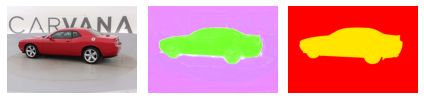

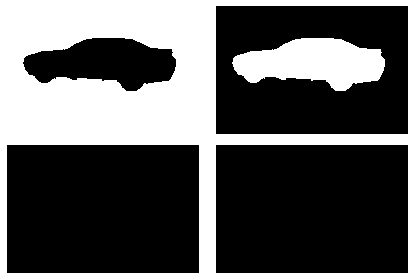

In [216]:
evaluate(net, val_loader, device = torch.device("cpu"))

In [3]:
def train_net(net,
              device,
              epochs: int = 5,
              batch_size: int = 1,
              learning_rate: float = 1e-5,
              val_percent: float = 0.1,
              save_checkpoint: bool = True,
              img_scale: float = 0.5,
              amp: bool = False):
    # 1. Create dataset
    dataset = BasicDataset(dir_img, dir_mask, img_scale)

    # 2. Split into train / validation partitions
    n_val = int(len(dataset) * val_percent)
    n_train = len(dataset) - n_val
    train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

    # 3. Create data loaders
    loader_args = dict(batch_size=batch_size, num_workers=4, pin_memory=True)
    train_loader = DataLoader(train_set, shuffle=True, **loader_args)
    val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

    # (Initialize logging)
    experiment = wandb.init(project='U-Net', resume='allow', anonymous='must')
    experiment.config.update(dict(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
                                  val_percent=val_percent, save_checkpoint=save_checkpoint, img_scale=img_scale,
                                  amp=amp))

    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Checkpoints:     {save_checkpoint}
        Device:          {device.type}
        Images scaling:  {img_scale}
        Mixed Precision: {amp}
    ''')

    # 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
    optimizer = optim.RMSprop(net.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    criterion = nn.CrossEntropyLoss()
    global_step = 0

    # 5. Begin training
    for epoch in range(1, epochs+1):
        net.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                images = batch['image']
                true_masks = batch['mask']

                assert images.shape[1] == net.n_channels, \
                    f'Network has been defined with {net.n_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32)
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.cuda.amp.autocast(enabled=amp):
                    masks_pred = net(images)
                    loss = criterion(masks_pred, true_masks) \
                           + dice_loss(F.softmax(masks_pred, dim=1).float(),
                                       F.one_hot(true_masks, net.n_classes).permute(0, 3, 1, 2).float(),
                                       multiclass=True)

                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                experiment.log({
                    'train loss': loss.item(),
                    'step': global_step,
                    'epoch': epoch
                })
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                division_step = (n_train // (10 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        histograms = {}
                        for tag, value in net.named_parameters():
                            tag = tag.replace('/', '.')
                            histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
                            histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

                        val_score = evaluate(net, val_loader, device)
                        scheduler.step(val_score)

                        logging.info('Validation Dice score: {}'.format(val_score))
                        experiment.log({
                            'learning rate': optimizer.param_groups[0]['lr'],
                            'validation Dice': val_score,
                            'images': wandb.Image(images[0].cpu()),
                            'masks': {
                                'true': wandb.Image(true_masks[0].float().cpu()),
                                'pred': wandb.Image(torch.softmax(masks_pred, dim=1).argmax(dim=1)[0].float().cpu()),
                            },
                            'step': global_step,
                            'epoch': epoch,
                            **histograms
                        })

        if save_checkpoint:
            Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
            torch.save(net.state_dict(), str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch)))
            logging.info(f'Checkpoint {epoch} saved!')





### Scripting Area

In [77]:
# Can you get this to work?
# I only changed section 1 and the other seemed to work

# I just randomly assigned values to the variables below
img_scale = 0.5
val_percent: float = 0.1

# 1. Create dataset
try:
    """
    Original code: dataset = CarvanaDataset(dir_img, dir_mask, img_scale)
    However, it is not loading the segmentation images (mask)
    as the mask_suffix is set to '_mask' in CarvanaDataset
    Instead. the mask_suffix should be simply '' so BasicDataset is used instead
    """
    dataset = BasicDataset(dir_img, dir_mask, img_scale)
except (AssertionError, RuntimeError):
    dataset = BasicDataset(dir_img, dir_mask, img_scale)

# 2. Split into train / validation partitions
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

# 3. Create data loaders
loader_args = dict(batch_size=batch_size, num_workers=4, pin_memory=True)
train_loader = DataLoader(train_set, shuffle=True, **loader_args)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

In [78]:
for batch in train_loader:
    image = batch['image']
    mask = batch['mask']
    break

(640, 959, 3)


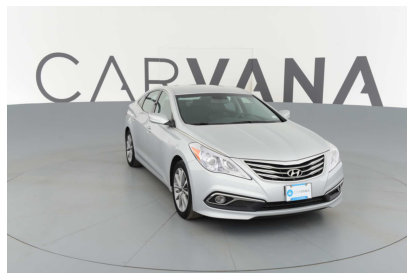

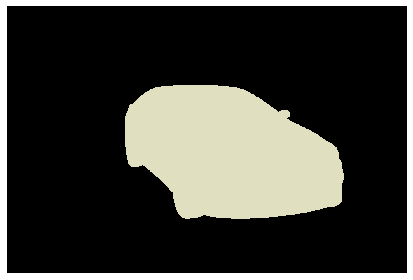

In [80]:
import torchshow as ts
ts.show(image[0])
ts.show(mask[0])

In [81]:
image.shape # N(batch number), C(Channels), H(Height of Image), W(Width of image)

torch.Size([1, 3, 640, 959])

In [23]:
### Can you start training the model on the cars dataset (starter code below)?

In [92]:
epochs = 5
batch_size = 1
learning_rate = 1e-5
load = False # initializes the weights randomly
# To initialize the pre-trainined weights:
# load = "C:\\2022_Summer_Intern\\UNet Training With Images\\Pre-trained\\unet_carvana_scale0.5_epoch2.pth"
scale = 0.5
amp = True
bilinear = False
classes = 2
val = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device {device}')

# Change here to adapt to your data
# n_channels=3 for RGB images
# n_classes is the number of probabilities you want to get per pixel
net = UNet(n_channels=3, n_classes=classes, bilinear=bilinear) # initializing random weights

print(f'Network:\n'
             f'\t{net.n_channels} input channels\n'
             f'\t{net.n_classes} output channels (classes)\n'
             f'\t{"Bilinear" if net.bilinear else "Transposed conv"} upscaling')

if load:
    net.load_state_dict(torch.load(load, map_location=device))
    logging.info(f'Model loaded from {load}')

net.to(device=device)


train_net(net=net,
          epochs=epochs,
          batch_size=batch_size,
          learning_rate=learning_rate,
          device=device,
          img_scale=scale,
          val_percent=val / 100,
          amp=amp)


pass

Using device cpu
Network:
	3 input channels
	2 output channels (classes)
	Transposed conv upscaling


Validation round: 100%|███████████████████████████████████████████████████████████████| 9/9 [00:38<00:00,  4.17s/batch]
                                                                                                                       C:\Users\s2137314\Anaconda3\envs\gel_env\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
Epoch 1/5:  32%|████████████████▍                                  | 28/87 [08:05<17:02, 17.34s/img, loss (batch)=0.35]


KeyboardInterrupt: 

In [15]:
test=None
print(not None)

True


In [5]:
modelweights = torch.load(f="C:\\2022_Summer_Intern\\UNet_Training_With_Images\\Pre-trained\\unet_carvana_scale0.5_epoch2.pth", map_location=torch.device("cpu"))
net.load_state_dict(state_dict = modelweights)

NameError: name 'net' is not defined

IndexError: index 1 is out of bounds for dimension 0 with size 1

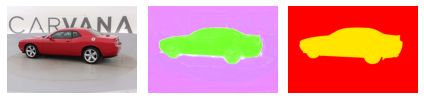

In [150]:
evaluate(net, val_loader, device = torch.device("cpu"))